**Author**: Ngu (Nathan) Dang

# Disaster Tweets Classification

### Table of Contents

0. [Import Essential Libraries](#importing)

1. Load The Training Dataset & EDA

    1.1 [Load the Data and Examine Some Statistics](#loading)
    
    1.2 [Text Analysis and Visualization](#visualizing)
    
2. [Data Processing](#data-processing)

3. Modelling

    3.1 [Construct The Model](#modeling)
    
    3.2 [Evaluate The Model](#evaluating)
    
4. [Submisison](#submission)

5. [Next Steps](#next-step)

### Overview

From the [Competition's Webpage](https://www.kaggle.com/competitions/nlp-getting-started/overview): Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take the following tweet as an example: "On plus side TAKE A LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE" (tweet source can be found [here](https://twitter.com/AnyOtherAnnaK/status/629195955506708480)). The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of over 10,000 tweets that were hand classified (specifically, 7613 tweets for training, and 3263 tweets for testing).

**Disclaimer**: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

### References

[1] [Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

[2] [BERT Language Model](https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model)

[3] [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert)

[4] [What is LSTM? Introduction to Long Short-Term Memory](https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce)

[5] [BERT || Transformer](https://www.kaggle.com/code/moemnelhalose/bert-transformers#Text-PreProcessing)

[6] [DTSA5511 - NLP Disastrous Tweets](https://www.kaggle.com/code/kyleakepanidtaworn/dtsa5511-nlp-disastrous-tweets)

# 0. Import Important Libraries <a name="importing"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import re
import string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional

from wordcloud import WordCloud, STOPWORDS

import torch
from torch.utils.data import DataLoader,Dataset

# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import AdamW

import keras_core as keras
import keras_nlp

import transformers
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


# 1. Loading The Training Dataset & EDA

## 1.1 Load The Data and Examine Some Statistics <a name="loading"></a>

First, we load the given training and testing datasets and quickly examine some statistics in the training set. 

In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
df_train.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

## 1.2 Text Analysis and Visualization <a name="visualizing"></a>

In this section, we perfrom some basic EDA for text data such as the word frequency distribution, text length distribution, most frequent words (excluding stopwords), as well as the distribution of the target labels. 

References: [1], [6]

In [8]:
# Add a length column to both DataFrames
df_train["length"] = df_train["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)
df_test["length"] = df_test["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Print statistical summary for train and test datasets
print("Train Length Statistics")
print(df_train["length"].describe())
print()

print("Test Length Statistics")
print(df_test["length"].describe())
print()

Train Length Statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Statistics
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64



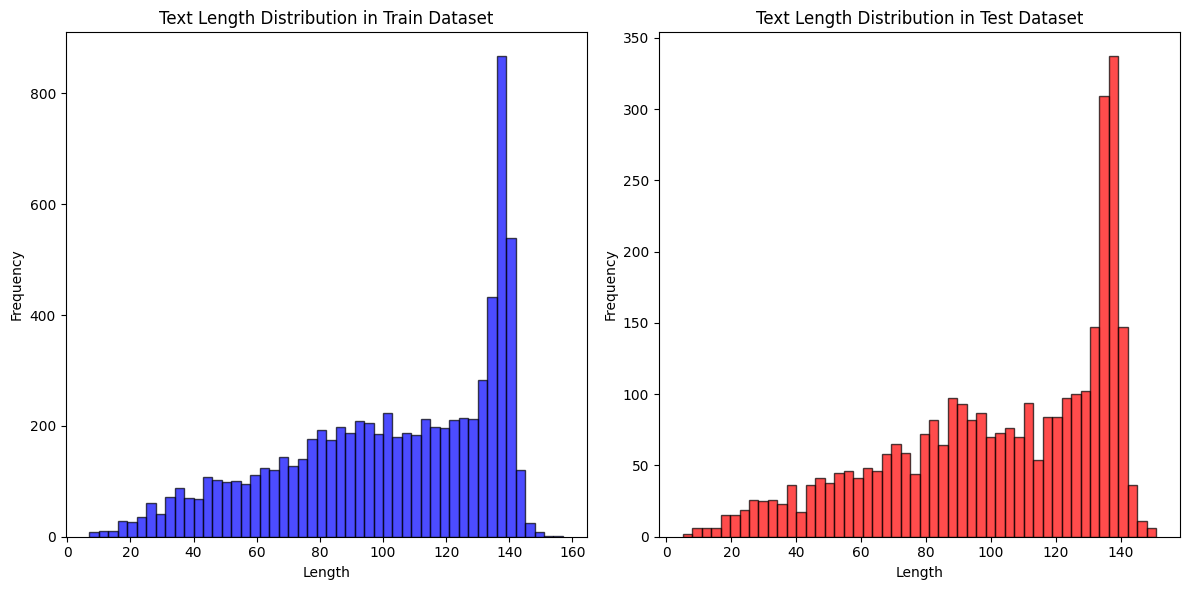

In [9]:
# Visualization of the text length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_train["length"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Text Length Distribution in Train Dataset')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_test["length"], bins=50, color='red', edgecolor='black', alpha=0.7)
plt.title('Text Length Distribution in Test Dataset')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

target
0    4342
1    3271
Name: count, dtype: int64


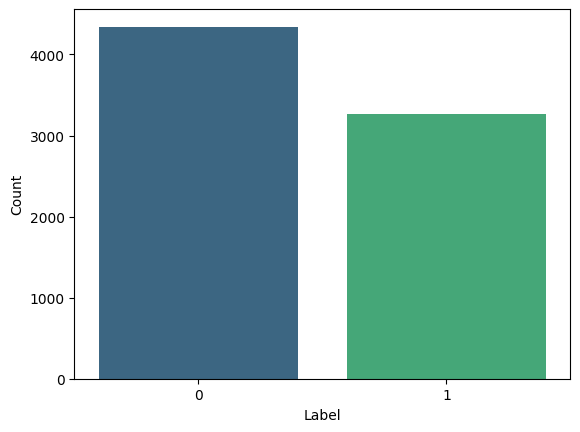

In [10]:
# Check the balance of the target variable
label_counts = df_train['target'].value_counts()
print(label_counts)

sns.countplot(x='target', data=df_train, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

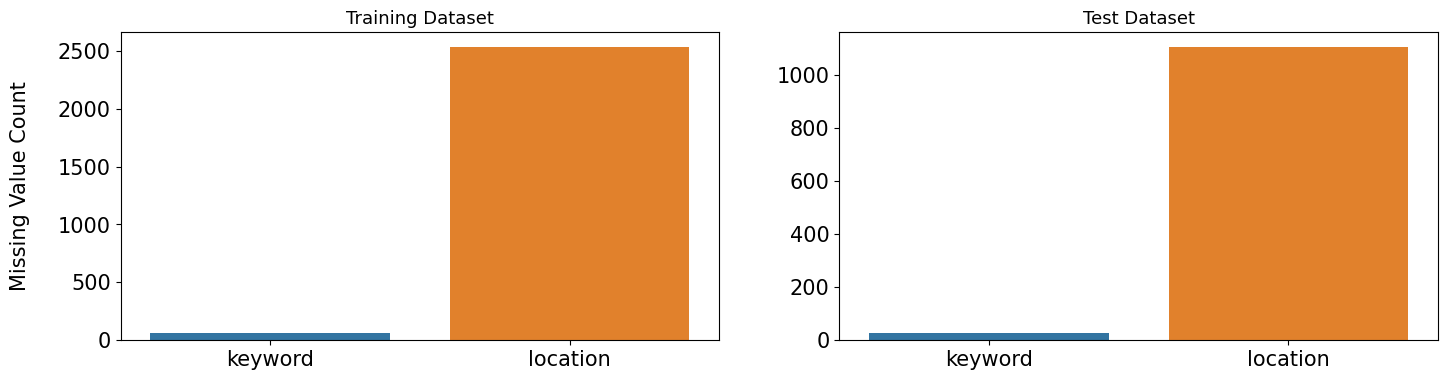

In [11]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Dataset', fontsize=13)
axes[1].set_title('Test Dataset', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [12]:
# Construct a dataframe containing top 20 most frequent words in the tweets (excluding stop words)

vectorizer = CountVectorizer(stop_words='english')
word_count_vector = vectorizer.fit_transform(df_train['text'])
word_counts = word_count_vector.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out() 

common_words_df = pd.DataFrame(sorted(list(zip(vocab, word_counts)), key=lambda x: x[1], reverse=True)[:20], 
                               columns=['Word', 'Count'])

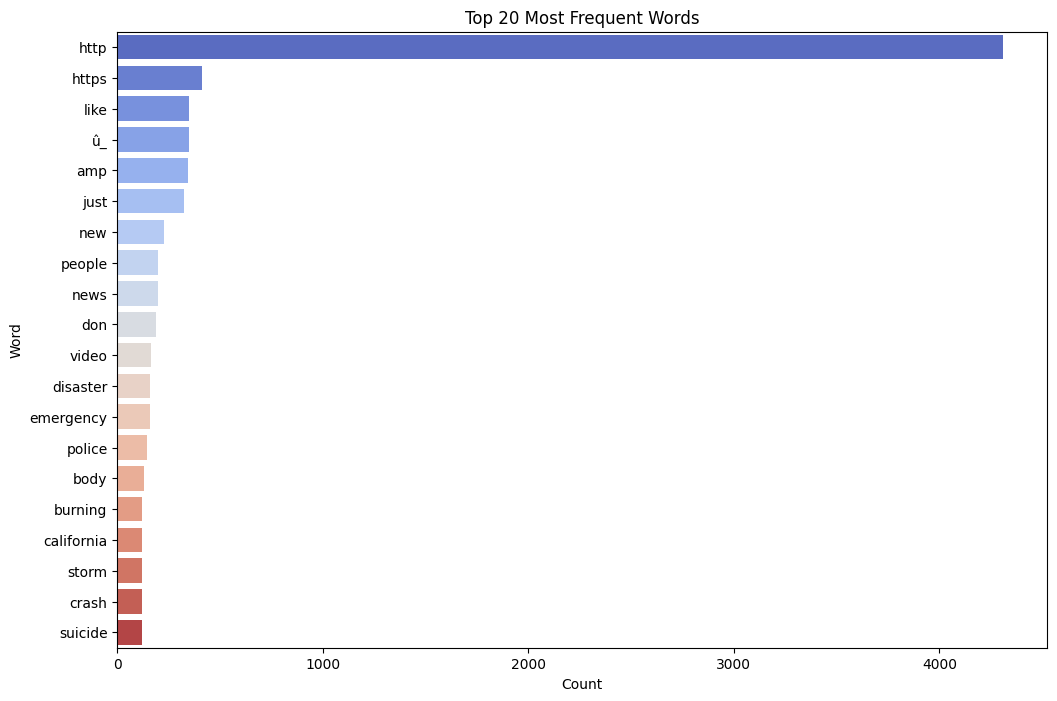

In [13]:
# Visualize top 20 most frequent words in the tweets (excluding stop words)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='coolwarm')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [14]:
corpus = []
all_tweets_words = df_train['text'].str.split()
all_tweets_words = all_tweets_words.values.tolist()
corpus = [word for tweets in all_tweets_words for word in tweets]

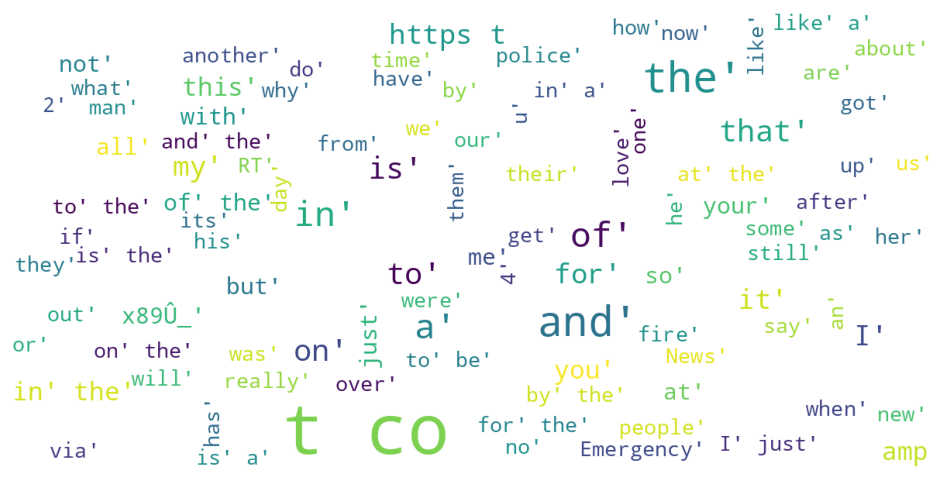

In [15]:
stop_words = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

**Summary of EDA:**

- Tweet Lengths: the training data shows tweets average around 100 characters, indicating consistent text length across samples.
- Target Variable Distribution: there's a slight imbalance in the data, with 4342 non-disaster and 3271 disaster-related tweets, which might need attention during model training. For instance, when splitting the data for training and evaluation, one might want to stratify the data to make sure the same ratio is given for both the training and evaluation sets.
- Both training and test set have same ratio of missing values in keyword and location. Specifically, 0.8% of keyword is missing in both training and test set, and 33% of location is missing in both training and test set. Since missing value ratios between training and test set are too close, they are most probably taken from the same sample.

# 2. Data Processing <a name="processing"></a>

In this section, we will clean the data by removing elements that are not useful for training such as stopwords, hyperlinks, special characters, hashtags, etc. 

References: [6]

In [16]:
stop = set(stopwords.words('english'))
# stemmer = PorterStemmer()

def clean_text(text):
    
    # Handle NaN values
    if pd.isna(text):  
        return ''
    # Put all text to lower-case
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove other special chars
    text=re.sub("\n"," ",text)
    text=re.sub(r"[^\w]"," ",text)
    text=re.sub("\w*\d\w*","",text)
    
    # Remove Stopwords
    text = " ".join([word for word in text.split() if word not in stop])
    # Apply Potter Stemmer
    # text = " ".join([stemmer.stem(word) for word in text.split()])
    
    return text

In [17]:
# Apply the cleaning function to the 'text' column
df_train['text'] = df_train['text'].apply(clean_text)
df_train.head()

,id,keyword,location,text,target,length
0,1,no_keyword,no_location,deeds reason may allah forgive us,1,69
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,38
2,5,no_keyword,no_location,residents asked shelter place notified officer...,1,133
3,6,no_keyword,no_location,people receive evacuation orders california,1,65
4,7,no_keyword,no_location,got sent photo ruby smoke pours school,1,88


In [18]:
# Extract the text and labels separately
all_train_text = df_train['text']
all_train_labels = df_train['target']

In [19]:
# re-visualizing the word frequency of the cleaned texts for sanity check

vectorizer = CountVectorizer(stop_words='english')
word_count_vector = vectorizer.fit_transform(all_train_text)
word_counts = word_count_vector.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out() 

common_words_df = pd.DataFrame(sorted(list(zip(vocab, word_counts)), key=lambda x: x[1], reverse=True)[:20], 
                               columns=['Word', 'Count'])

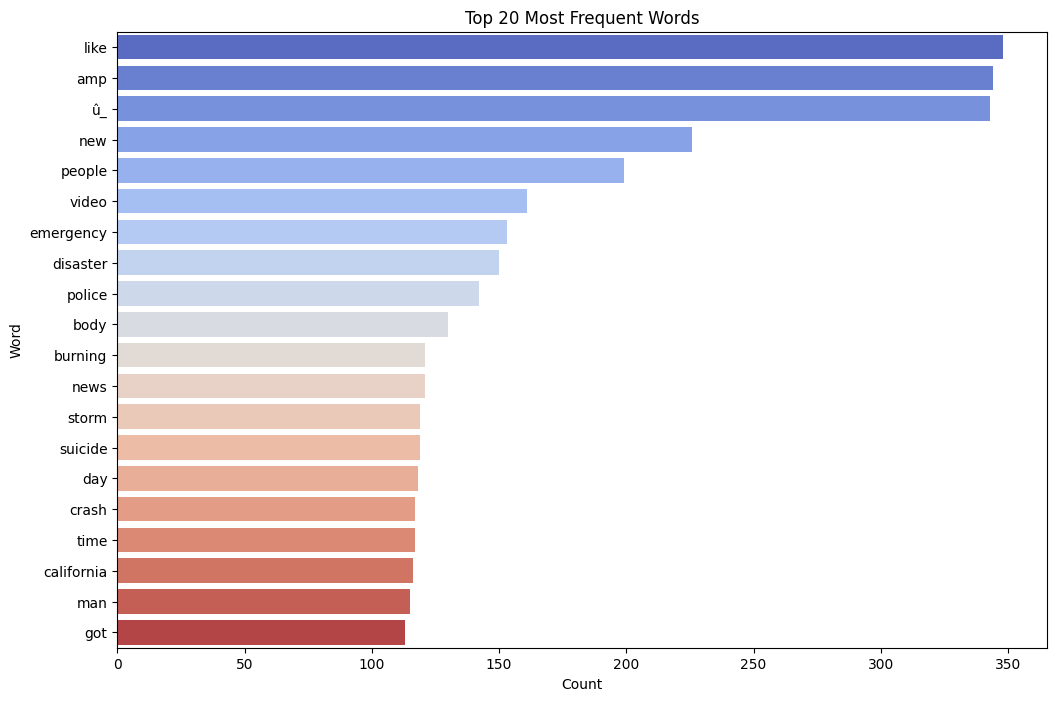

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='coolwarm')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

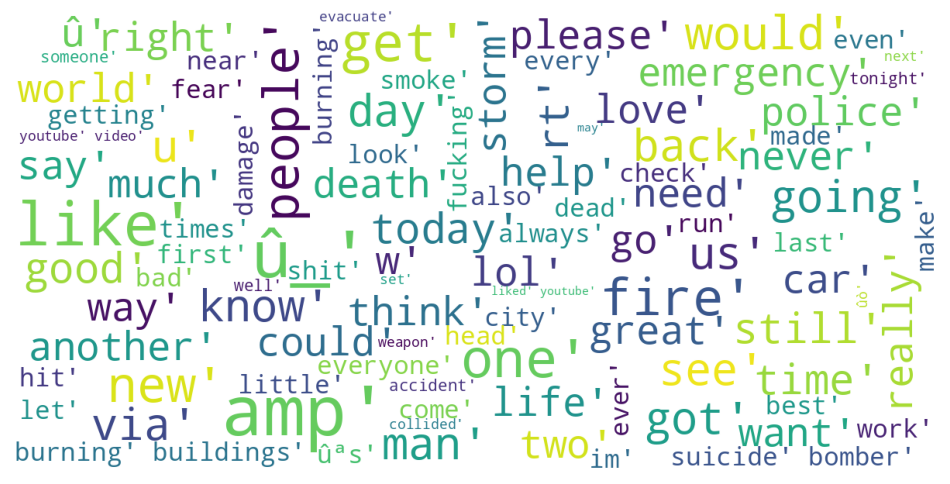

In [21]:
cleaned_corpus = []
all_cleaned_tweets_words = all_train_text.str.split()
all_cleaned_tweets_words = all_cleaned_tweets_words.values.tolist()
cleaned_corpus = [word for tweets in all_cleaned_tweets_words for word in tweets]

show_wordcloud(cleaned_corpus)

# 3. Modelling

## 3.1 Construct The Model <a name="modelling"></a>

In this section, we construct two different models, the DistilBERT by HuggingFace and a customized LSTM model and then compare the performance of both.

References: [3], [4], [5], [6]

In [22]:
# Split the full training dataset to train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(all_train_text, 
                                                                    all_train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=df_train['target'])

In [23]:
# Load a DistilBERT model.
preset = "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
model_bert = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                          preprocessor = preprocessor, 
                                                          num_classes=2)

model_bert.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the Model
model_bert.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics= ["accuracy"]  
)

In [25]:
# Train the DistilBERT Model
# NOTE: use GPU to accelerate the training process if possible

NUM_EPOCHS = 3
BATCH_SIZE = 32

history_bert = model_bert.fit(x=train_texts,
                              y=train_labels,
                              epochs=NUM_EPOCHS,
                              batch_size=BATCH_SIZE ,
                              validation_data=(val_texts, val_labels)
                             )

Epoch 1/3


I0000 00:00:1724884915.189168     260 service.cc:145] XLA service 0x7c07c8003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724884915.189219     260 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724884953.050870     260 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 124 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_xor_fusion_122', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1724884953.103633     260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7168 - loss: 0.5751

I0000 00:00:1724885030.144521     260 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 124 bytes spill stores, 124 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.7171 - loss: 0.5747 - val_accuracy: 0.8260 - val_loss: 0.4104
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 241ms/step - accuracy: 0.8226 - loss: 0.4212 - val_accuracy: 0.8332 - val_loss: 0.3943
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 241ms/step - accuracy: 0.8603 - loss: 0.3616 - val_accuracy: 0.8326 - val_loss: 0.4069


In [26]:
# Define LSTM model architecture
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=20000, output_dim=128, input_length=100))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Process the data differently for the second model, 
# e.g. manually create the training sequences from texts

# Create the tokenizer object
tokenizer = Tokenizer(num_words=20000, lower=True)

# Fit tokenizer on the processed text
tokenizer.fit_on_texts(all_train_text.values)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(all_train_text.values)

# Pad sequences
max_len = 100
all_train_padded_text = pad_sequences(train_sequences, maxlen=max_len)

In [28]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_train_padded_text, 
                                                  all_train_labels, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  stratify=df_train['target'])

In [29]:
# Train the LSTM Model
NUM_EPOCHS = 3
BATCH_SIZE = 32

history_lstm = model_lstm.fit(X_train, y_train, 
                             epochs=NUM_EPOCHS, 
                             batch_size=BATCH_SIZE, 
                             validation_data=(X_val, y_val), verbose=2
                             )

Epoch 1/3
191/191 - 49s - 256ms/step - accuracy: 0.7005 - loss: 0.5736 - val_accuracy: 0.7958 - val_loss: 0.4544
Epoch 2/3
191/191 - 42s - 220ms/step - accuracy: 0.8599 - loss: 0.3356 - val_accuracy: 0.8043 - val_loss: 0.4524
Epoch 3/3
191/191 - 42s - 221ms/step - accuracy: 0.9250 - loss: 0.2059 - val_accuracy: 0.7866 - val_loss: 0.5533


## 3.2 Evaluate The Model <a name="evaluating"></a>

In this section, we evaluate the perfomance of the contructed model by plotting the training and evaluation accuracy and loss. 

References: [6]

In [30]:
# Evaluate the DistilBERT model
val_loss, val_accuracy = model_bert.evaluate(val_texts, val_labels, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.4068593382835388
Validation Accuracy: 0.8325672745704651


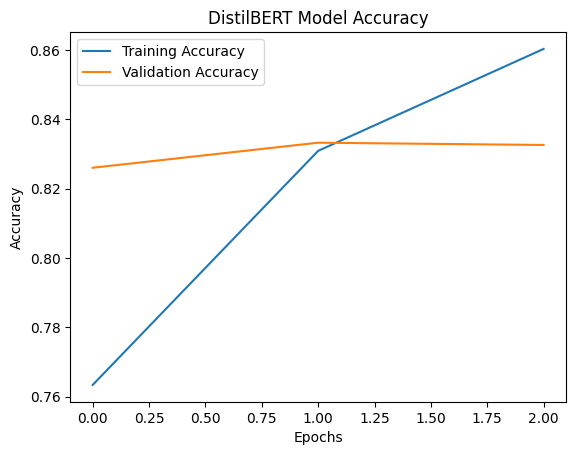

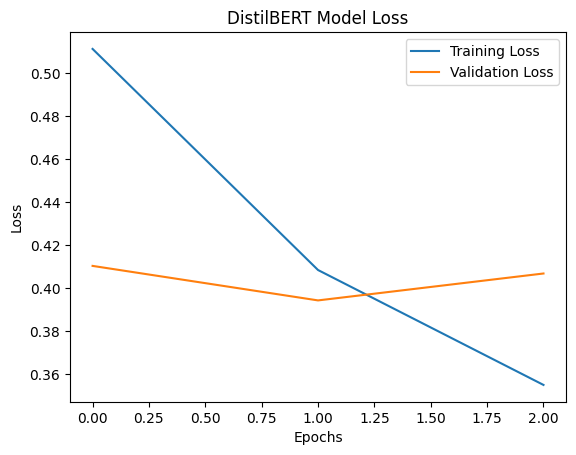

In [31]:
# Plot accuracy
plt.plot(history_bert.history['accuracy'], label='Training Accuracy')
plt.plot(history_bert.history['val_accuracy'], label='Validation Accuracy')
plt.title('DistilBERT Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_bert.history['loss'], label='Training Loss')
plt.plot(history_bert.history['val_loss'], label='Validation Loss')
plt.title('DistilBERT Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Evaluate the DistilBERT model
val_loss, val_accuracy = model_lstm.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.553257942199707
Validation Accuracy: 0.7866053581237793


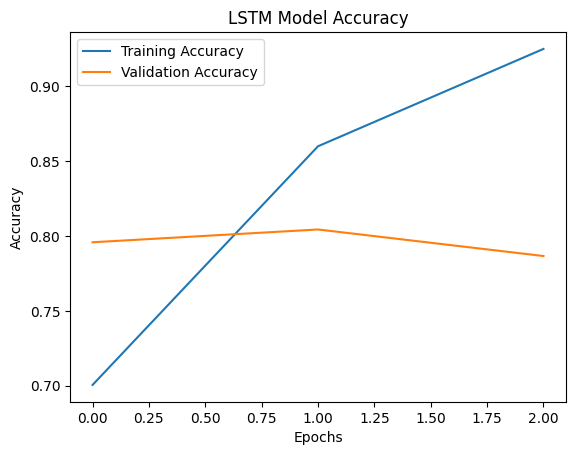

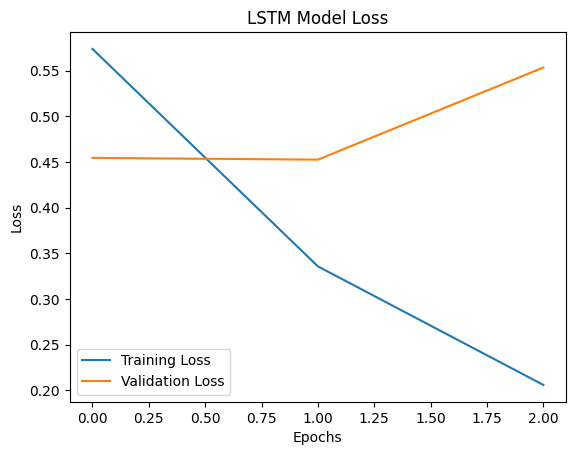

In [33]:
# Plot accuracy
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Submission <a name="submission"></a>

In this section, we choose the DistilBERT model as our final model and prepare the submission file.

In [34]:
# Apply the cleaning function to the 'text' column of the test data
df_test['text'] = df_test['text'].apply(clean_text)
df_test.head()

,id,keyword,location,text,length
0,0,no_keyword,no_location,happened terrible car crash,34
1,2,no_keyword,no_location,heard different cities stay safe everyone,64
2,3,no_keyword,no_location,forest fire spot pond geese fleeing across str...,96
3,9,no_keyword,no_location,apocalypse lighting,40
4,11,no_keyword,no_location,typhoon soudelor kills china taiwan,45


In [35]:
# Extract the text separately
all_test_text = df_test['text']

# # Convert text to sequences
# test_sequences = tokenizer.texts_to_sequences(all_test_text.values)

# # Pad sequences
# max_len = 100
# all_test_padded_text = pad_sequences(test_sequences, maxlen=max_len)

In [36]:
# Make predictions on the test data
test_predictions = np.argmax(model_bert.predict(all_test_text), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step


In [37]:
# Prepare the Submission File
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions
})

In [38]:
# Check the first few rows of the submission file
print(submission.head())

# Save the file
submission.to_csv('/kaggle/working/submission.csv', index=False)

   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1


# 5. Next Steps <a name="next-steps"></a>

The obvious next step is to fine tune the parameters of the models. Another useful thing to try is to construct different types of models for comparision, e.g. use vanilla BERT [2] and see if it shows any significant improvement compared to DistilBERT for this particular problem.